# Predizioni second wave - **SCIPY**

- si focalizza sulla second wave
- si analizza come va l'esponenziale e da li si estrapolano le tendenze per altre misure (es. terapie intensive)

In [15]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aidam.math_utils import moving_function_rev1
#from aidam.aicharts import get_subplot_cells_sequence, confplot_ax,auto_grid_shape
#from aidam.faga.curve_fit import FagaCurveFit
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from aidam.miscellanea_utils import find_matlabstyle

from covid_lib import read_covid_data, find_day_index

## Lettura dati

In [2]:
trend,regioni,giorni,giorno_settimana,popolazione,day_counter=read_covid_data('stored_data.pkl')

Giorni osservati: 278
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-11-27T17:00:00


## Estrapolazione second wave

Inizio nominale second wave: 2020-09-11T17:00:00
Valore deceduti_giornalieri a inizio second wave: 10.000000


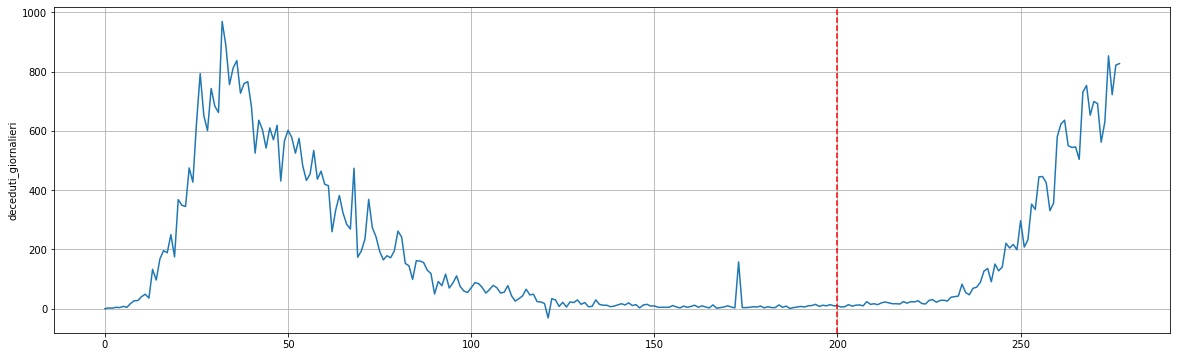

In [9]:
indicatore='deceduti_giornalieri'

# giorno di inizio second wave
if indicatore=='terapia_intensiva':
    sw_start=160
if indicatore=='deceduti_giornalieri':
    sw_start=200
if indicatore=='nuovi_positivi':
    sw_start=200

print('Inizio nominale second wave: %s'%giorni[sw_start])


fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(day_counter,trend[indicatore]['Italia'])
ax.grid()
ax.set_ylabel(indicatore)
ax.axvline(sw_start,c='r',ls='--')


Y=trend[indicatore]['Italia'][sw_start:]


print('Valore %s a inizio second wave: %f'%(indicatore,trend[indicatore]['Italia'][sw_start]))

## Fitting con esponenziale


### Definizione funzioni base

- esponenziale generica $y=y0+ak^{bt}$
- gaussiana generica
- doppia gaussina

In [10]:
def generic_expo(t,y0,a,k,b):
    return y0+a*k**(b*t)


def generic_gaussian(t,a,b,c):
    return a*np.exp(-((t-b)**2)/(2*c**2))

def double_gaussian(t,a1,b1,c1,a2,b2,c2):
    return a1*np.exp(-((t-b1)**2)/(2*c1**2))+a2*np.exp(-((t-b2)**2)/(2*c2**2))

## Fitting con scipy curve_fit

In [5]:
# generico

modello_usato=generic_gaussian
solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y)
solution

array([3.55747625e+04, 6.22922769e+01, 1.69950706e+01])

In [17]:
# per predizione deceduti:
# il parametro b considera il ritardo del picco dei deceduti 
# rispetto a quello dei nuovi positivi (circa un mese) avvenuto intorno al 15 novembre
picco_nuovi_positivi=find_day_index(giorni,'2020-11-15')[0]

params_range=((700,picco_nuovi_positivi-sw_start+25,10),
              (2000,picco_nuovi_positivi-sw_start+45,35))

modello_usato=generic_gaussian
solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=params_range)
solution

array([949.57851206,  90.        ,  24.83476936])

### Simulazione

In [18]:
simulation_days=np.arange(len(Y)+30)
y_pred=np.array(list(map(lambda x:modello_usato(x,*solution),simulation_days)))

Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [19]:
giorno0=datetime.strptime(giorni[sw_start][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(200):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

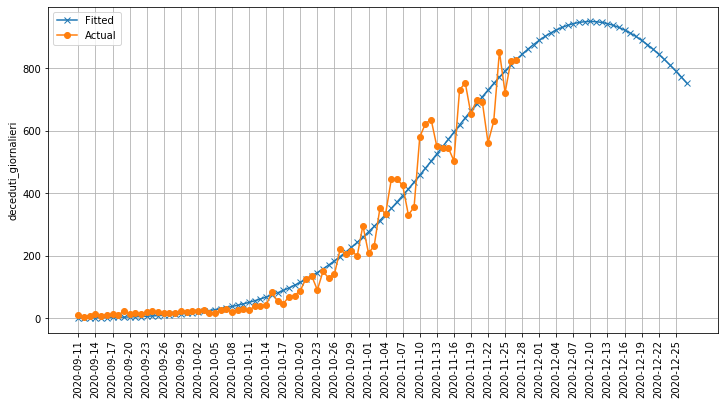

In [20]:
fig,ax=plt.subplots(1,figsize=(12,6))
ax.plot(simulation_days,y_pred,label='Fitted',marker='x')
ax.plot(range(len(Y)),Y,label='Actual',marker='o')
ax.grid()
ax.set_xticks(list(range(0,len(simulation_days),3)))
ax.set_xticklabels(str_giorni[list(range(0,len(simulation_days),3))],rotation=90)

ax.set_ylabel(indicatore)
ax.legend()


In [61]:
for d in simulation_days:
    if d<len(Y):
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],Y[d],y_pred[d]))
    else:
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],0,y_pred[d]))   

[  0]  2020-09-11  Act:   1616 Pred: 31.5
[  1]  2020-09-12  Act:   1501 Pred: 39.4
[  2]  2020-09-13  Act:   1458 Pred: 49.3
[  3]  2020-09-14  Act:   1008 Pred: 61.3
[  4]  2020-09-15  Act:   1229 Pred: 76.0
[  5]  2020-09-16  Act:   1452 Pred: 94.0
[  6]  2020-09-17  Act:   1585 Pred: 115.6
[  7]  2020-09-18  Act:   1907 Pred: 141.8
[  8]  2020-09-19  Act:   1638 Pred: 173.3
[  9]  2020-09-20  Act:   1587 Pred: 210.9
[ 10]  2020-09-21  Act:   1350 Pred: 255.8
[ 11]  2020-09-22  Act:   1392 Pred: 309.1
[ 12]  2020-09-23  Act:   1640 Pred: 372.1
[ 13]  2020-09-24  Act:   1786 Pred: 446.3
[ 14]  2020-09-25  Act:   1912 Pred: 533.4
[ 15]  2020-09-26  Act:   1869 Pred: 635.0
[ 16]  2020-09-27  Act:   1766 Pred: 753.2
[ 17]  2020-09-28  Act:   1494 Pred: 890.2
[ 18]  2020-09-29  Act:   1648 Pred: 1048.1
[ 19]  2020-09-30  Act:   1851 Pred: 1229.5
[ 20]  2020-10-01  Act:   2548 Pred: 1437.0
[ 21]  2020-10-02  Act:   2499 Pred: 1673.3
[ 22]  2020-10-03  Act:   2844 Pred: 1941.3
[ 23]  2020-

## Confronto fra ottimizzazioni multiple

### Set di parametri

Dizionario di parametri: ad ogni nome associo una lista di parametri